# Introduction to Reinforcement Learning Course - Project
Group Members: Iulia-Elena Teodorescu, Konstantinos Tantoulas, Likhith Bedara Agrahara Venkateshamurthy

## Import libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Implementation


In [2]:
# Grid dimensions
n_rows, n_cols = 11, 11
actions = ['up', 'down', 'left', 'right']

# Rewards
reward_matrix = np.full((n_rows, n_cols), -100.)
DEPOSIT_REWARD = 100
CHARGING_REWARD = -5
OPEN_AREA_REWARD = -1
COLLISION_PENALTY = -50

# Charging and deposit stations
charging_stations = [(1, 1), (5, 1), (9, 9)]
deposit_stations = [(0, 5), (5, 0), (10, 5)]

# Added Robot types with unique attributes
robot_types = {
    "small": {"speed": 2, "capacity": 1, "recharge_rate": 2},
    "large": {"speed": 1, "capacity": 3, "recharge_rate": 1},
    "fast_recharge": {"speed": 1, "capacity": 2, "recharge_rate": 3},
}

# Initialize Q-values
q_matrix = np.zeros((n_rows, n_cols, 4))

# Define open areas
open_areas = {1: list(range(1, 10)), 2: [1, 7, 9], 3: list(range(1, 10)),
              4: [3, 7], 5: list(range(1, 10)), 6: [1, 3, 4, 5, 9],
              7: [1, 3, 4, 5, 6, 7, 8, 9], 8: [1, 3, 7, 9],
              9: [1, 2, 3, 4, 5, 6, 7, 9]}

# Assign rewards to grid
def assign_rewards():
    for row in range(1, 10):
        for col in open_areas[row]:
            reward_matrix[row, col] = OPEN_AREA_REWARD

    for row, col in deposit_stations:
        reward_matrix[row, col] = DEPOSIT_REWARD

    for row, col in charging_stations:
        reward_matrix[row, col] = CHARGING_REWARD

assign_rewards()

#  Added Initialize robots with unique attributes
def initialize_robots(num_robots):
    robots = []
    for _ in range(num_robots):
        robot_type = random.choice(list(robot_types.keys()))
        robots.append({
            "type": robot_type,
            "position": random_start(),
            "energy": 100,
            "has_package": False,
            "speed": robot_types[robot_type]["speed"],
            "capacity": robot_types[robot_type]["capacity"],
            "recharge_rate": robot_types[robot_type]["recharge_rate"],
        })
    return robots

# Random starting position
def random_start():
    valid_positions = [(r, c) for r, cols in open_areas.items() for c in cols]
    return valid_positions[np.random.randint(len(valid_positions))]

# Added Task assignment based on proximity and energy level
def assign_tasks(robots, tasks):
    assignments = {}
    for task in tasks:
        closest_robot = None
        min_distance = float("inf")
        for i, robot in enumerate(robots):
            if robot["energy"] > 0:
                distance = calculate_manhattan_distance(robot["position"], task)
                if distance < min_distance:
                    min_distance = distance
                    closest_robot = i
        if closest_robot is not None:
            assignments[closest_robot] = task
    return assignments

# Manhattan distance calculation
def calculate_manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Action selection using epsilon-greedy
def select_action(row, col, epsilon_value):
    if np.random.random() < epsilon_value:
        return np.random.randint(4)
    return np.argmax(q_matrix[row, col])

# Calculate next position
def calculate_next_position(row, col, action):
    if actions[action] == 'up' and row > 0:
        row -= 1
    elif actions[action] == 'right' and col < n_cols - 1:
        col += 1
    elif actions[action] == 'down' and row < n_rows - 1:
        row += 1
    elif actions[action] == 'left' and col > 0:
        col -= 1
    return row, col

# Move toward charging station
def move_toward_charger(row, col, target_row, target_col):
    if row < target_row:
        return row + 1, col
    elif row > target_row:
        return row - 1, col
    elif col < target_col:
        return row, col + 1
    elif col > target_col:
        return row, col - 1
    return row, col



## Training Agents

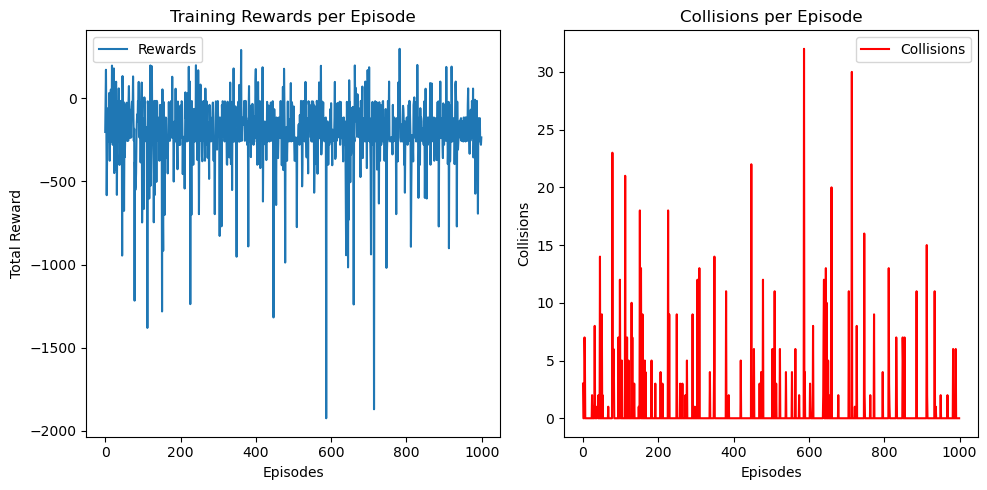

In [3]:
# Simulation parameters
epsilon = 1.0
gamma = 0.9
alpha = 0.9
episodes = 1000
max_steps = 100
num_robots = 3
rewards = []
collisions_per_episode = []

for episode in range(episodes):
    robots = initialize_robots(num_robots)
    tasks = [random_start() for _ in range(len(robots))]
    task_assignments = assign_tasks(robots, tasks) # Closest robot with sufficient energy is dynamically assigned to each task
    total_reward = 0
    collision_count = 0

    for step in range(max_steps):
        occupied_positions = set()

        for i, robot in enumerate(robots):
            if i not in task_assignments:
                continue

            task = task_assignments[i]
            row, col = robot["position"]

            # Check energy and recharge if needed
            if robot["energy"] <= 10:
                charging_station = move_toward_charger(row, col, *random.choice(charging_stations)) # Added to select a charging station, adding randomness
                next_row, next_col = move_toward_charger(row, col, *charging_station)
                if (next_row, next_col) == charging_station:
                    robot["energy"] = min(100, robot["energy"] + robot["recharge_rate"]) # Robot energy is recharged incrementally 
                    reward = CHARGING_REWARD
                else:
                    reward = OPEN_AREA_REWARD
            else:
                action = select_action(row, col, epsilon)
                next_row, next_col = calculate_next_position(row, col, action)

                # Added Check for collisions
                # Now Collision penalty is directly applied without retries
                if (next_row, next_col) in occupied_positions:
                    collision_count += 1
                    reward = COLLISION_PENALTY
                else:
                    occupied_positions.add((next_row, next_col))
                    if (next_row, next_col) == task:
                        robot["has_package"] = False
                        reward = DEPOSIT_REWARD
                        task_assignments.pop(i)  # Task is removed from task_assignments once completed
                    else:
                        reward = OPEN_AREA_REWARD
                        # Added to handles rewards directly in the task loop rather than relying entirely on reward_matrix

            q_current = q_matrix[row, col, action]
            td_error = reward + gamma * np.max(q_matrix[next_row, next_col]) - q_current
            q_matrix[row, col, action] += alpha * td_error

            robot["position"] = (next_row, next_col)
            robot["energy"] -= 1 # Energy decreases by a fixed amount (1) for each step, regardless of the action
            total_reward += reward

        epsilon = max(0.01, epsilon * 0.995)

    rewards.append(total_reward)
    collisions_per_episode.append(collision_count)

# Visualization
plt.figure(figsize=(10, 5))

# Rewards plot
plt.subplot(1, 2, 1)
plt.plot(rewards, label="Rewards")
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Rewards per Episode')
plt.legend()

# Collisions plot
plt.subplot(1, 2, 2)
plt.plot(collisions_per_episode, label="Collisions", color='red')
plt.xlabel('Episodes')
plt.ylabel('Collisions')
plt.title('Collisions per Episode')
plt.legend()

plt.tight_layout()
plt.show()